# Problem Statement

Santander wants to find which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

#### This kernels consists of : 

* LGB
* Gradient Boosting
* Linear Regression
* Decision Tree
 
 Modelling and relevant scoring

In [2]:
import pickle
import boto3
import numpy as np
#s3://santander-starter-train/modeldtr/
filename = 'dtr_New_1.sav'
#loaded_model = pickle.load(open(filename, 'rb'))
#pickle.dump(reg, open(filename, 'wb'))
# some time later...
#s3_resource = boto3.resource('s3')
#s3_resource.Object('santander-starter-train','modeldtr/dtr_New_1.sav').put(Body=open(filename, 'rb'))
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(x_test,y_test)
#y_prediction= loaded_model.predict(x_test)
#print(y_prediction)

## Load dictionary for ProdRecommendation
import boto3
import pickle
s3_resource = boto3.resource('s3')
filename = 'ProdRecommed.npy'
dicttprodrec = s3_resource.Object('santander-starter-train','dictionaries/ProdRecommed.npy').download_file(filename)
daf= np.load("ProdRecommed.npy",allow_pickle='TRUE').item()
daf[0]

{0: 'Current Accounts',
 1: 'Short-term deposits',
 2: 'Current Accounts, Direct Debit',
 3: 'Current Accounts, e-account',
 4: '',
 5: 'Current Accounts, e-account, Direct Debit',
 6: 'Current Accounts, e-account, Securities',
 7: 'Payroll Account, e-account, Direct Debit',
 8: 'e-account',
 9: 'Payroll Account, e-account, Taxes, Direct Debit',
 10: 'Payroll Account, e-account, Securities, Direct Debit',
 11: 'Payroll Account, e-account, Taxes, Credit Card, Payroll, Direct Debit',
 12: 'Direct Debit',
 13: 'Payroll Account, Payroll, Direct Debit',
 14: 'Payroll Account, Payroll',
 15: 'Payroll Account',
 16: 'Payroll Account, e-account, Payroll, Direct Debit',
 17: 'e-account, Credit Card, Direct Debit',
 18: 'Payroll Account, e-account, Payroll',
 19: 'Current Accounts, Taxes, Direct Debit',
 20: 'Current Accounts, Más particular Account',
 21: 'Junior Account',
 22: 'Payroll Account, e-account',
 23: 'Current Accounts, Long-term deposits, e-account',
 24: 'Payroll Account, e-account

In [3]:
import gc
import os
import time
import math
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

from sklearn.metrics import roc_auc_score
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

# Importing all models

# Classification
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, \
    RandomForestRegressor, VotingRegressor


#import lightgbm as lgb
#import xgboost as xgb
#import catboost as cat
#from catboost import Pool, CatBoostClassifier

import warnings
#print(os.listdir("../input"))
warnings.simplefilter('ignore')

In [4]:
total_start_time = time.time()

# Importing Data and Reducing Memory

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [6]:
traintesting = import_data("s3://santander-starter-train/PreProcessedtrainingdata/traintesting_PreProcessed.csv")
##test = import_data("test_ver2.csv")
##sub = import_data("sample_submission.csv")

##print("\n\nTrain Size : \t{}\nTest Size : \t{}".format(train.shape, test.shape))


Memory usage of dataframe is 2498.90 MB
Memory usage after optimization is: 780.91 MB
Decreased by 68.7%


In [7]:
traintesting.head()

,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,is_foreigner,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment,ProductRecommed
0,20150128.0,1375586.0,1.0,0.0,2.0,35.0,20150112.0,0.0,6.0,1.0,...,1.0,2.0,0.0,0.0,1.0,29.0,1.0,87218.101562,3.0,0.0
1,20150128.0,1050611.0,1.0,0.0,1.0,23.0,20120810.0,0.0,35.0,1.0,...,2.0,2.0,1.0,0.0,1.0,13.0,0.0,35548.738281,3.0,0.0
2,20150128.0,1050612.0,1.0,0.0,1.0,23.0,20120810.0,0.0,35.0,1.0,...,1.0,2.0,1.0,0.0,1.0,13.0,0.0,122179.109375,3.0,0.0
3,20150128.0,1050613.0,1.0,0.0,2.0,22.0,20120810.0,0.0,35.0,1.0,...,1.0,2.0,2.0,0.0,1.0,50.0,0.0,119775.539062,3.0,1.0
4,20150128.0,1050614.0,1.0,0.0,1.0,23.0,20120810.0,0.0,35.0,1.0,...,1.0,2.0,1.0,0.0,1.0,50.0,1.0,134254.312500,3.0,0.0


In [6]:
traintesting.columns #PrinceG : 
#Train data has 24 columns to be used as features. Last 24 columsn represent the product to be recommended

Index(['date', 'customer_code', 'emp_status', 'residence_code', 'sex', 'age',
       'date_first_prod', 'new_customer', 'seniority_inmonths',
       'prime_customer', 'prime_lastdate', 'customer_type',
       'customer_relation', 'is_residence', 'is_foreigner', 'spouse',
       'channel', 'deceased', 'primary_address', 'province_code', 'status_ai',
       'gincome', 'social_segment', 'ProductRecommed'],
      dtype='object')

In [7]:
## verify which all columns have Null / NaN values
traintesting.isnull().sum()

date                  0
customer_code         0
emp_status            0
residence_code        0
sex                   0
age                   0
date_first_prod       0
new_customer          0
seniority_inmonths    0
prime_customer        0
prime_lastdate        0
customer_type         0
customer_relation     0
is_residence          0
is_foreigner          0
spouse                0
channel               0
deceased              0
primary_address       0
province_code         0
status_ai             0
gincome               0
social_segment        0
ProductRecommed       0
dtype: int64

In [8]:
traintesting = traintesting.astype('float64')

# Modelling


! pip install catboost

import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import Pool, CatBoostClassifier
def baseliner_clas(train, feat, target, cv, metric):

    eval_dict = {}
    models = [lgb.LGBMClassifier()]
    # LogisticRegression(), SVC(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), ExtraTreeClassifier(), AdaBoostClassifier(), BaggingClassifier(),
    # RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(), xgb.XGBClassifier(), cat.CatBoostClassifier(verbose=0)

    for model in models:
        model_name = str(model).split("(")[0]
        results = cross_val_score(model, train[feat], train[target], cv=cv,
                                  scoring=metric)
        print(model_name, results.mean(), results)
        eval_dict[model_name] = results.mean()

    return eval_dict

base_1 = baseliner_clas(traintesting, traintesting.drop(["ProductRecommed"], axis=1), traintesting['ProductRecommed'], 3, 'roc_auc')

### Documentation related to LGBM:   https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [40]:
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 20.8 MB/s eta 0:00:01


In [41]:
#from sklearn.LGBMModel import lightgbm
import lightgbm as lgb
def lgb_model(train, feat, target):
    x_train, x_valid, y_train, y_valid = train_test_split(traintesting.drop(["ProductRecommed"], axis=1), traintesting['ProductRecommed'], test_size=0.2, random_state=13)

    train_set = lgb.Dataset(x_train, label=y_train)
    valid_set = lgb.Dataset(x_valid, label=y_valid)

    MAX_ROUNDS = 2000
    params = {
        "boosting": 'gbdt', # "dart",
        "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        #"objective": "Regression",
        "metric": "mse",
        "metric": "None"
    }

    model = lgb.train(
        params,
        train_set=train_set,
        valid_sets=[train_set, valid_set],
        #early_stopping_rounds=50,
        verbose_eval=100
    )

    lgb.plot_importance(model, figsize=(24, 50))

    return model

# LGB Feature Importance 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.286353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1511
[LightGBM] [Info] Number of data points in the train set: 10917847, number of used features: 22
[LightGBM] [Info] Start training from score 176.573715


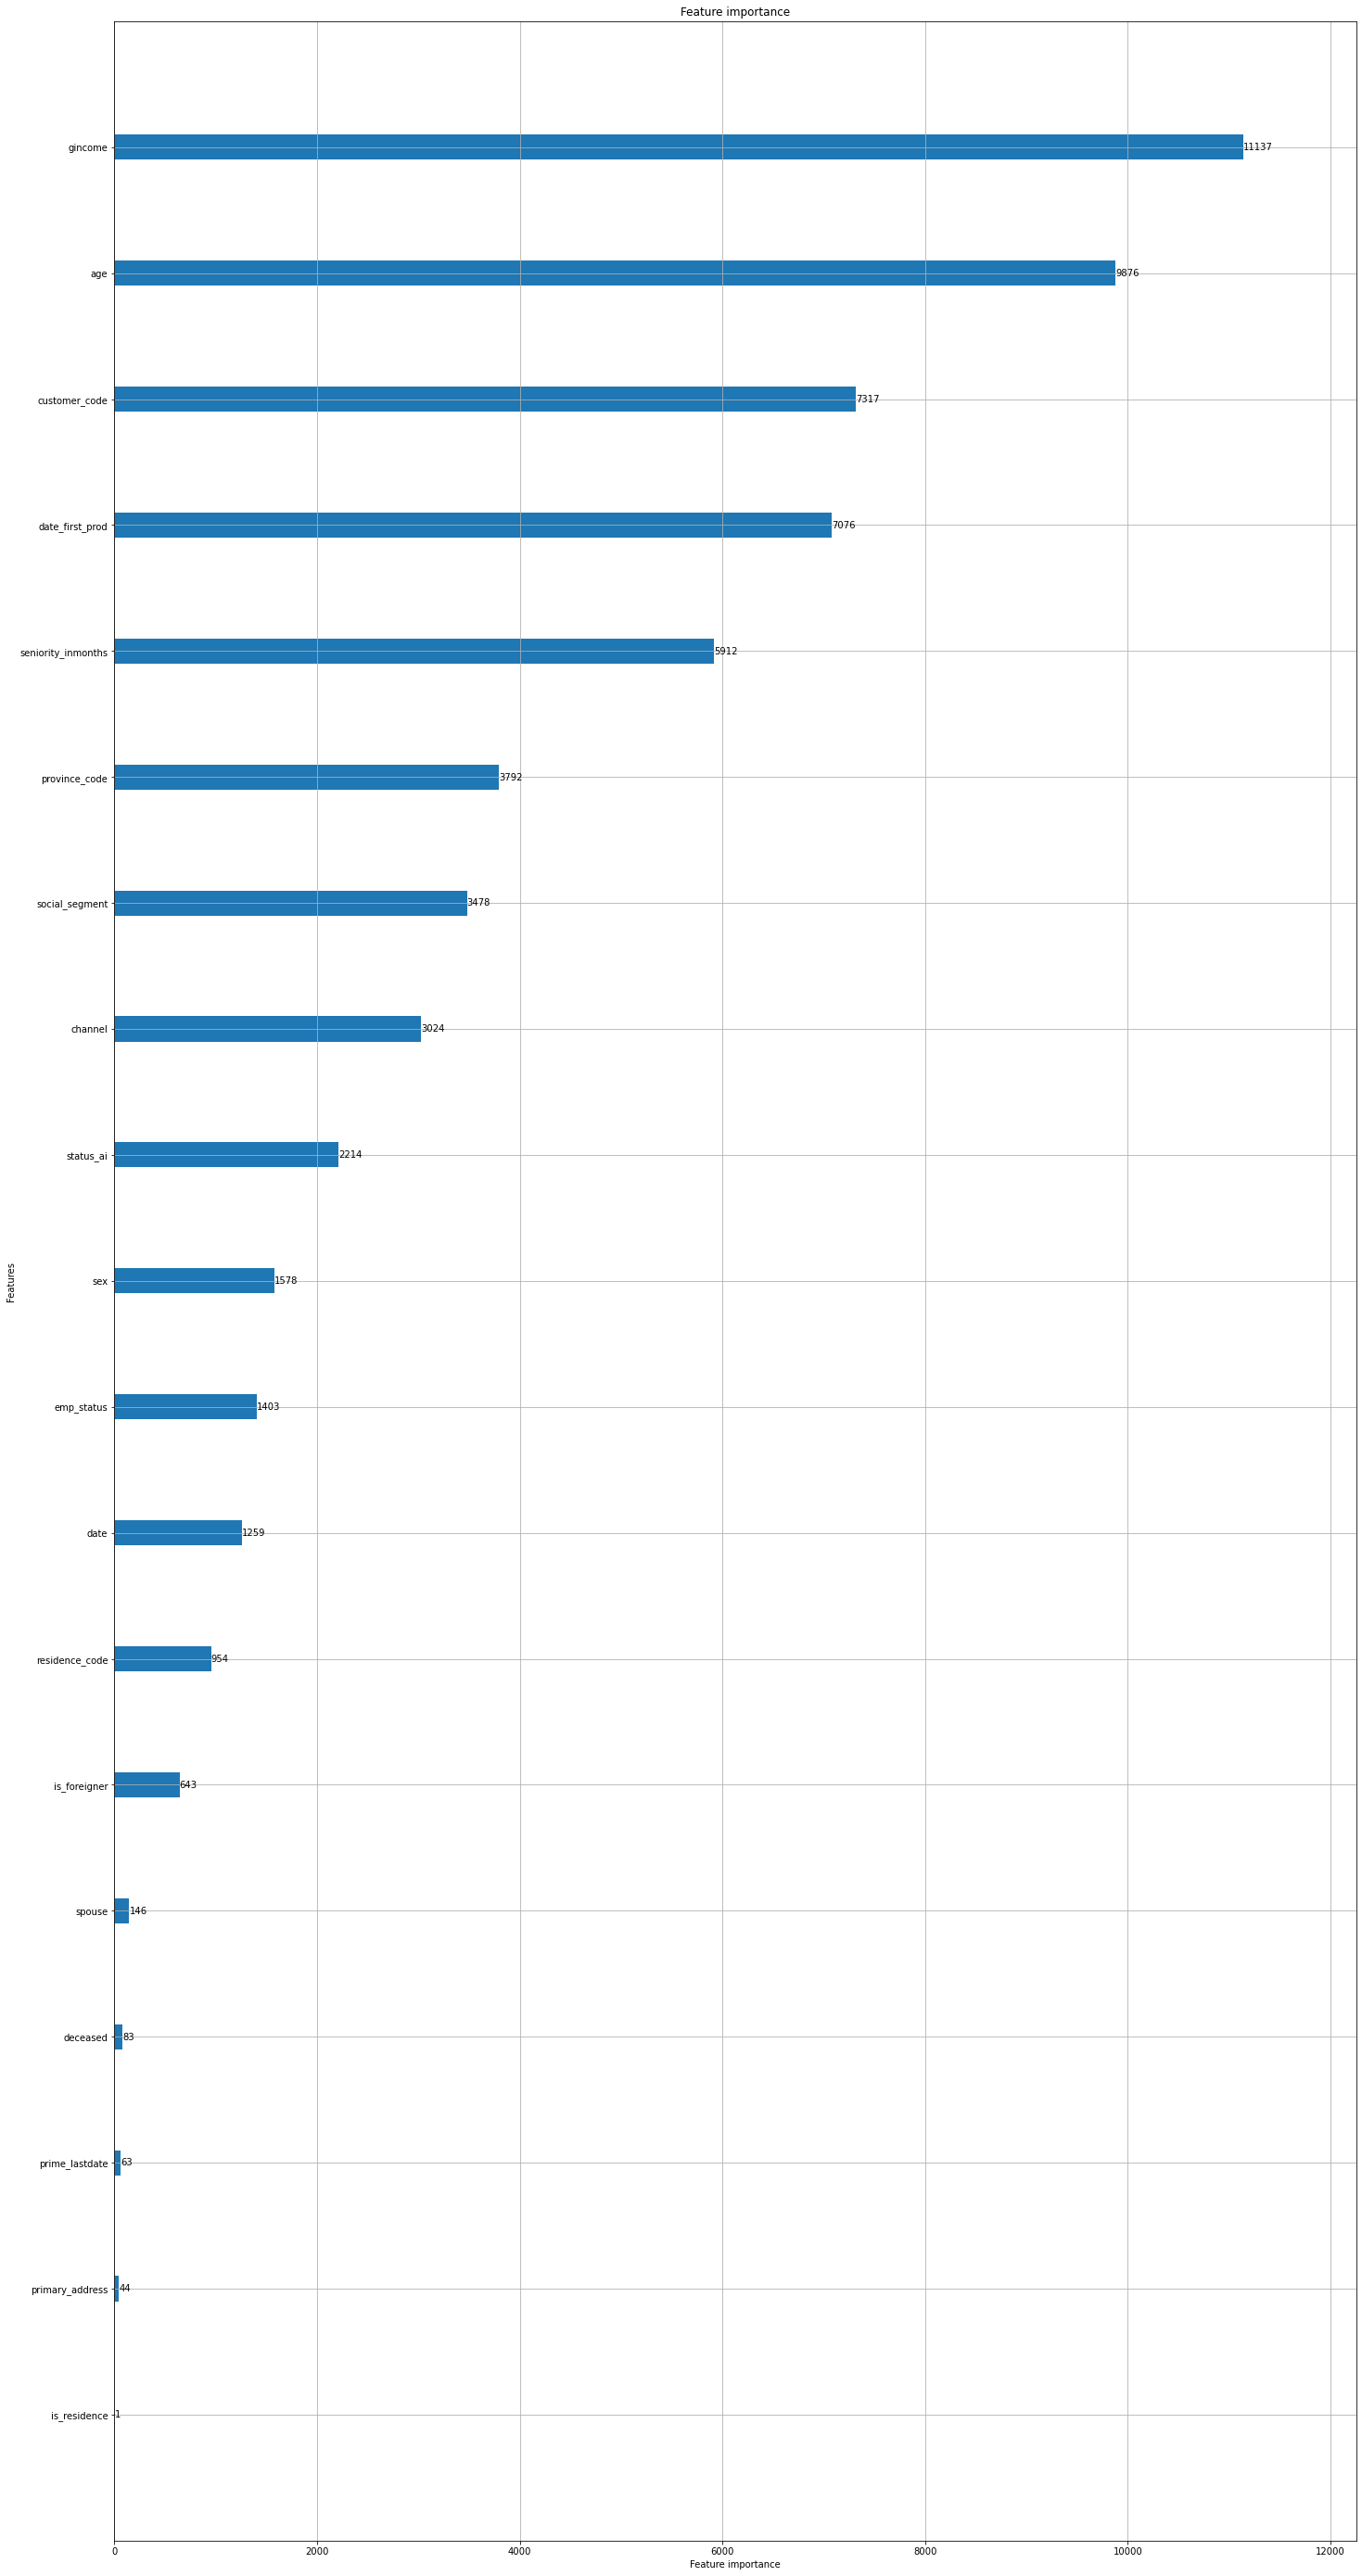

In [42]:
model = lgb_model(traintesting, traintesting.drop(["ProductRecommed"], axis=1), traintesting['ProductRecommed'])

In [54]:
#Prediction
x_train, x_valid, y_train, y_valid = train_test_split(traintesting.drop(["ProductRecommed"], axis=1), traintesting['ProductRecommed'], test_size=0.2, random_state=13)
y_pred=model.predict(x_valid)

In [55]:
#y_pred
y_pred1= y_pred.astype('int64')

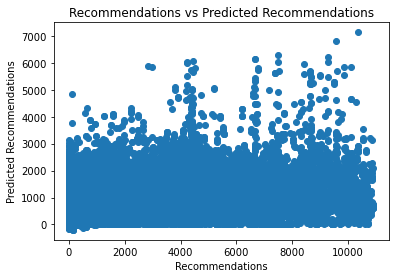

In [56]:
plt.scatter(y_valid, y_pred1)
plt.xlabel("Recommendations")
plt.ylabel("Predicted Recommendations")
plt.title("Recommendations vs Predicted Recommendations")
plt.show()

In [57]:
##
x_valid['ProdRecommed'] = y_valid
x_valid['ProdRecommedPredict'] = y_pred1
x_valid['ProdRecommed'].astype('str')
#daf= np.load("s3://santander-starter-train/dictionaries/ProdRecommed.npy",allow_pickle='TRUE').item()
#daf= np.load("ProdRecommed.npy",allow_pickle='TRUE').item()
#daf[0].astype('str')
x_valid['ProdRecommed'] = x_valid['ProdRecommed'].map(daf[0])
#x_valid['ProdRecommed'] = x_valid['ProdRecommed'].remap(daf)
x_valid['ProdRecommedPredict'] = x_valid['ProdRecommedPredict'].map(daf[0])

In [58]:
x_valid

,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment,ProdRecommed,ProdRecommedPredict
13044013,20160528.0,127040.0,1.0,0.0,2.0,44.0,19990404.0,0.0,206.0,1.0,...,2.0,5.0,0.0,1.0,28.0,1.0,90723.687500,3.0,"Current Accounts, Payroll Account, particular ...","Payroll Account, Long-term deposits, Credit Ca..."
3183259,20150628.0,1042712.0,1.0,0.0,2.0,41.0,20120804.0,0.0,35.0,1.0,...,2.0,1.0,0.0,1.0,8.0,1.0,91011.539062,3.0,"Current Accounts, Direct Debit","Payroll Account, Payroll"
3708289,20150628.0,506552.0,1.0,0.0,2.0,57.0,20041214.0,0.0,127.0,1.0,...,2.0,23.0,0.0,1.0,41.0,0.0,75419.398438,3.0,particular Account,"Payroll Account, e-account, Taxes, Credit Card..."
296346,20150128.0,1200302.0,1.0,0.0,1.0,23.0,20131016.0,0.0,21.0,1.0,...,2.0,1.0,0.0,1.0,28.0,0.0,84902.492188,3.0,Current Accounts,Current Accounts
6532425,20151028.0,1035422.0,1.0,0.0,1.0,24.0,20120730.0,0.0,39.0,1.0,...,2.0,1.0,0.0,1.0,41.0,0.0,108533.070312,3.0,Current Accounts,Current Accounts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10296386,20160228.0,648743.0,1.0,0.0,1.0,43.0,20061016.0,0.0,100.0,1.0,...,2.0,71.0,0.0,1.0,28.0,0.0,73694.523438,3.0,,Junior Account
1310650,20150328.0,444671.0,1.0,0.0,1.0,55.0,20031112.0,0.0,140.0,1.0,...,2.0,5.0,0.0,1.0,28.0,0.0,137846.843750,3.0,Current Accounts,"e-account, Taxes, Credit Card, Payroll, Direct..."
12474186,20160428.0,1012170.0,1.0,0.0,1.0,11.0,20120412.0,0.0,48.0,1.0,...,2.0,3.0,0.0,1.0,28.0,1.0,142969.859375,3.0,Junior Account,"Payroll Account, Long-term deposits, e-account..."
1490040,20150328.0,368245.0,1.0,0.0,1.0,69.0,20020704.0,0.0,6.0,1.0,...,2.0,0.0,0.0,1.0,29.0,1.0,124218.093750,3.0,Current Accounts,"Current Accounts, e-account, Taxes, Credit Card"


In [59]:
import sklearn.metrics as metrics
print('R^2:',metrics.r2_score(y_valid, y_pred1))
#print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_valid, y_pred1))
print('MSE:',metrics.mean_squared_error(y_valid, y_pred1))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_valid, y_pred1)))

R^2: 0.2821807928066473
MAE: 167.59692239716105
MSE: 246691.65441431315
RMSE: 496.6806362385322


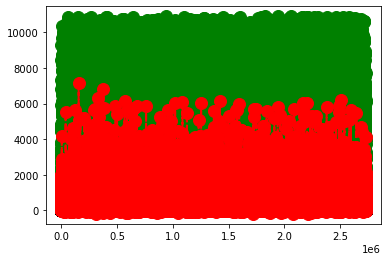

In [60]:
plt.plot(np.arange(len(y_valid)),y_valid ,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(np.arange(len(y_pred)),y_pred ,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)

## LGB does not seem to give the good rsults as values are not aligned

In [50]:
#Save the LGB Model 
import pickle
import boto3
#s3://santander-starter-train/modeldtr/
filename = 'lgb.sav'
#loaded_model = pickle.load(open(filename, 'rb'))
pickle.dump(model, open(filename, 'wb'))
# some time later...
s3_resource = boto3.resource('s3')
s3_resource.Object('santander-starter-train','modelsagemaker/lgb.sav').put(Body=open(filename, 'rb'))


{'ResponseMetadata': {'RequestId': 'ZQ5CS5RD6NE9ZJPA',
  'HostId': 'xK/zEhachdY+Nfk/nV/fA8lAiXXnOhwN98PMwr4KuvAvh2GMbbkxzz9aruRSdCuzSZkGi2NE0no=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'xK/zEhachdY+Nfk/nV/fA8lAiXXnOhwN98PMwr4KuvAvh2GMbbkxzz9aruRSdCuzSZkGi2NE0no=',
   'x-amz-request-id': 'ZQ5CS5RD6NE9ZJPA',
   'date': 'Mon, 22 Mar 2021 19:11:24 GMT',
   'x-amz-version-id': 'SLEqXBwWTOz8IkFVPKe4LROsoXlJDEfR',
   'etag': '"0389598fd2cf0c9dbfc65d843f393974"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"0389598fd2cf0c9dbfc65d843f393974"',
 'VersionId': 'SLEqXBwWTOz8IkFVPKe4LROsoXlJDEfR'}

In [52]:
## Download the Model and run Prediction
import boto3
import pickle
s3_resource = boto3.resource('s3')
filename = 'lgb.sav'
objectfile = s3_resource.Object('santander-starter-train','modelsagemaker/lgb.sav').download_file(filename)
lgbmodel = pickle.load(open(filename, 'rb'))
x_train, x_valid, y_train, y_valid = train_test_split(traintesting.drop(["ProductRecommed"], axis=1), traintesting['ProductRecommed'], test_size=0.2, random_state=13)
y_pred=lgbmodel.predict(x_valid)

## Gradient Boosting Model

In [9]:
traintesting1 = traintesting

In [10]:
start_time = time.time()
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#X, y = make_regression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(traintesting1.drop(['ProductRecommed'], axis=1), traintesting1['ProductRecommed'],test_size = 0.30, random_state= 355)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)


print('Done. Time elapsed for Gradient Boost Model Training: {:.2f}s'.format(time.time() - start_time))

Done. Time elapsed for Gradient Boost Model Training: 2426.62s


In [11]:
y_prd_grad = reg.predict(X_test)

reg.score(X_test, y_test)

0.257722490571316

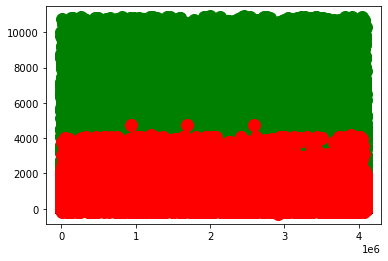

In [12]:
plt.plot(np.arange(len(y_test)),y_test ,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(np.arange(len(y_prd_grad)),y_prd_grad ,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)

In [14]:
## Save GB Model
import pickle
import boto3
#s3://santander-starter-train/modeldtr/
filename = 'gbm.sav'
#loaded_model = pickle.load(open(filename, 'rb'))
pickle.dump(reg, open(filename, 'wb'))
# some time later...
s3_resource = boto3.resource('s3')
s3_resource.Object('santander-starter-train','modelsagemaker/gbm.sav').put(Body=open(filename, 'rb'))

{'ResponseMetadata': {'RequestId': 'SA5XCQGPE63VGZSA',
  'HostId': 'hBOdhabTLyaWZu0wwXB0MY4HCMhqifiaWvT+OMLdiXleX3jYTL7I920U6i4B3YP2MkLT6V3F7Vk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'hBOdhabTLyaWZu0wwXB0MY4HCMhqifiaWvT+OMLdiXleX3jYTL7I920U6i4B3YP2MkLT6V3F7Vk=',
   'x-amz-request-id': 'SA5XCQGPE63VGZSA',
   'date': 'Tue, 23 Mar 2021 10:15:42 GMT',
   'x-amz-version-id': 'dqsSySx8.6HyokiylBKW9TjRxbKuLHm4',
   'etag': '"578110b9395e2356b02107ed2800ca45"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"578110b9395e2356b02107ed2800ca45"',
 'VersionId': 'dqsSySx8.6HyokiylBKW9TjRxbKuLHm4'}

## Gradeint Booster has given only 25.6% score thus not relevant for our case

## Linar Regression

In [7]:
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets 
lm.fit(traintesting.drop(['ProductRecommed'], axis=1), traintesting['ProductRecommed'])

LinearRegression()

In [8]:
lm.intercept_

12305.366814577916

In [9]:
coeffcients = pd.DataFrame([traintesting.columns,lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

,Attribute,Coefficients
0,date,-0.000502921
1,customer_code,-1.52424e-06
2,emp_status,299.408
3,residence_code,-0.692058
4,sex,-9.18007
5,age,-1.51127
6,date_first_prod,-0.00328963
7,new_customer,17.5763
8,seniority_inmonths,-0.00128176
9,prime_customer,-142.353


int_cols = traintesting.select_dtypes(include=np.int).columns.to_list()
bool_cols = []
disc_cols = []

for col in int_cols:
    print(f'{col}-----{traintesting[col].nunique()}')
    print('-'  * 30)
    print(f'{traintesting[col].unique()}')
    print('='  * 30)
    
    if traintesting[col].nunique() > 2:
        disc_cols.append(col)
    else:
        bool_cols.append(col)

In [10]:
y_pred = lm.predict(traintesting.drop(['ProductRecommed'], axis=1))

In [11]:
y_train = traintesting['ProductRecommed']
import sklearn.metrics as metrics
print('R^2:',metrics.r2_score(y_train, y_pred))
#print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.19069759004382203
MAE: 224.52943969794572
MSE: 275726.01624569827
RMSE: 525.0961971350566


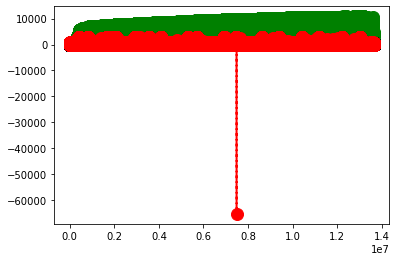

In [12]:
plt.plot(np.arange(len(y_train)),y_train ,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(np.arange(len(y_pred)),y_pred ,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)

## MSE and RMSE values are too high for Linear Regression model can not consider this model

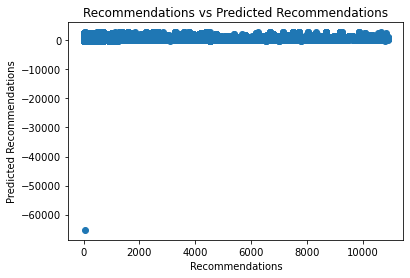

In [13]:
plt.scatter(y_train, y_pred)
plt.xlabel("Recommendations")
plt.ylabel("Predicted Recommendations")
plt.title("Recommendations vs Predicted Recommendations")
plt.show()

In [14]:
import pickle
import boto3
#s3://santander-starter-train/modeldtr/
filename = 'linearreg.sav'
#loaded_model = pickle.load(open(filename, 'rb'))
pickle.dump(lm, open(filename, 'wb'))
# some time later...
s3_resource = boto3.resource('s3')
s3_resource.Object('santander-starter-train','modelsagemaker/linearreg.sav').put(Body=open(filename, 'rb'))
#linearregmodel = 's3://santander-starter-train/modelsagemaker/linearreg.sav'
#y_predlm = linearregmodel.predict(traintesting.drop(['ProductRecommed'], axis=1))
#y_predlm

{'ResponseMetadata': {'RequestId': 'CK8HH1VGNG807945',
  'HostId': 'dLF0729bKae0YEPPZ0npDQG1lID+2q0CvV4CQ4I4uoJzJQJq0LkPFA5FFsxQqlK4le7D/OiG/co=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'dLF0729bKae0YEPPZ0npDQG1lID+2q0CvV4CQ4I4uoJzJQJq0LkPFA5FFsxQqlK4le7D/OiG/co=',
   'x-amz-request-id': 'CK8HH1VGNG807945',
   'date': 'Mon, 22 Mar 2021 15:41:34 GMT',
   'x-amz-version-id': 'r9jPTxo._1XtOwyRGqFBXK7uesduJL2a',
   'etag': '"d722a02eb668025fe9c625f768d75f6f"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"d722a02eb668025fe9c625f768d75f6f"',
 'VersionId': 'r9jPTxo._1XtOwyRGqFBXK7uesduJL2a'}

In [39]:
#with open('linearreg.sav', 'wb') as data:
#linearregmodel = s3_resource.Object('santander-starter-train','modelsagemaker/linearreg.sav').download_fileobj('linearreg.sav', 'rb')
import boto3
import pickle
s3_resource = boto3.resource('s3')
filename = 'linearreg.sav'
objectfile = s3_resource.Object('santander-starter-train','modelsagemaker/linearreg.sav').download_file(filename)
linmodel = pickle.load(open(filename, 'rb'))
y_pred = linmodel.predict(traintesting.drop(['ProductRecommed'], axis=1))

y_pred

array([ 42.56495991, -27.05000952, -21.94849862, ...,  86.96249067,
       -61.49743594,  18.50573305])

for col in disc_cols:
    print(f'{col} ----- ', pd.to_numeric(traintesting[col], downcast = 'integer').dtype)
    traintesting[col] = pd.to_numeric(traintesting[col], downcast = 'integer')

traintesting[bool_cols] = traintesting[bool_cols].astype(np.bool_)

cont_cols = traintesting.select_dtypes(include=np.float_).columns.to_list()
cont_int_cols = []
cont_float_cols = []

for col in cont_cols:
    print(f'{col}-----{traintesting[col].nunique()}')
    print('-'  * 30)
    print(f'{traintesting[col].unique()}')
    print('='  * 30)
    if traintesting[col].nunique() < 5 : 
        cont_int_cols.append(col)
    else:
        cont_float_cols.append(col)  

# Decision Tree

In [15]:
## Decision Tree Model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report


In [16]:
x_train,x_test,y_train,y_test = train_test_split(traintesting.drop(['ProductRecommed'], axis=1), traintesting['ProductRecommed'],test_size = 0.30, random_state= 355)

x_train.to_csv('x_train_stand_starter.csv')
y_train.to_csv('y_train_stand_starter.csv')
x_test.to_csv('x_test_stand_starter.csv')
y_test.to_csv('y_test_stand_starter.csv')

x_train=pd.read_csv('x_train_stand_starter.csv')
y_train=pd.read_csv('y_train_stand_starter.csv')
x_test=pd.read_csv('x_test_stand_starter.csv')
y_test=pd.read_csv('y_test_stand_starter.csv')

In [17]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
reg = DecisionTreeRegressor()
reg.fit(x_train,y_train)

DecisionTreeRegressor()

In [18]:
y_prediction = reg.predict(x_test)
#reg.score(x_test,y_test)

## Decision Tree Regressor has been giving 78% score the best so far

In [19]:
reg.score(x_test,y_test)

0.7815593690663116

In [23]:
## Save DTR Model
import pickle
import boto3
#s3://santander-starter-train/modeldtr/
filename = 'dtr.sav'
#loaded_model = pickle.load(open(filename, 'rb'))
pickle.dump(reg, open(filename, 'wb'))
# some time later...
s3_resource = boto3.resource('s3')
s3_resource.Object('santander-starter-train','modelsagemaker/dtr.sav').put(Body=open(filename, 'rb'))

{'ResponseMetadata': {'RequestId': 'E35D2MS22JZ5S5GG',
  'HostId': 'hJtYKugv/6f0g57TS0CH2Tz18Y6SZpVwWLIXSZ5TPw90kUoZ27ERnYZLj2ghtaNwXaXM+nEg2Zk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'hJtYKugv/6f0g57TS0CH2Tz18Y6SZpVwWLIXSZ5TPw90kUoZ27ERnYZLj2ghtaNwXaXM+nEg2Zk=',
   'x-amz-request-id': 'E35D2MS22JZ5S5GG',
   'date': 'Tue, 23 Mar 2021 10:21:32 GMT',
   'x-amz-version-id': 'RKpb9_7MmuVW3uy50bckiDBY7zj_vzJJ',
   'etag': '"9d4e74281c84b96b68cb7131c5883bcd"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"9d4e74281c84b96b68cb7131c5883bcd"',
 'VersionId': 'RKpb9_7MmuVW3uy50bckiDBY7zj_vzJJ'}

from sklearn.ensemble import AdaBoostRegressor
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(),n_estimators=300, random_state=300)

regr_2.fit(x_train,y_train)

regr_2.score(x_test,y_test)

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(reg, grid_param, cv=5)

traintesting= ''
grid_search.fit(x_train,y_train)
best_parameters = grid_search.best_params_
print(best_parameters)

grid_search.best_score_

reg = DecisionTreeRegressor(criterion= 'mse', max_depth=2, max_leaf_nodes= 5, min_samples_leaf= 20, min_samples_split= 10)
reg.fit(x_train,y_train)

reg.score(x_test,y_test)

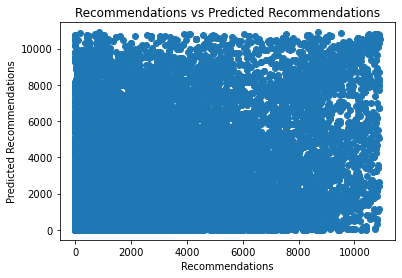

In [20]:
plt.scatter(y_test, y_prediction)
plt.xlabel("Recommendations")
plt.ylabel("Predicted Recommendations")
plt.title("Recommendations vs Predicted Recommendations")
plt.show()

In [38]:
#y_predict

In [21]:
##
x_test['ProdRecommed'] = y_test
x_test['ProdRecommedPredict'] = y_prediction
x_test['ProdRecommed'].astype('str')
daf= np.load('ProdRecommed.npy',allow_pickle='TRUE').item()
#daf[0].astype('str')
x_test['ProdRecommed'] = x_test['ProdRecommed'].map(daf[0])
#x_test['ProdRecommed'] = x_test['ProdRecommed'].remap(daf)
x_test['ProdRecommedPredict'] = x_test['ProdRecommedPredict'].map(daf[0])

In [22]:
#x_test.replace({"ProdRecommed": daf[0]})
#x_test.replace({"ProdRecommedPredict": daf[0]})
x_test


,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment,ProdRecommed,ProdRecommedPredict
6483685,20151028.0,1061305.0,1.0,0.0,2.0,27.0,20120916.0,0.0,37.0,1.0,...,2.0,2.0,0.0,1.0,28.0,1.0,211074.359375,3.0,"Payroll Account, Taxes","Payroll Account, Taxes, Direct Debit"
828346,20150228.0,66187.0,1.0,0.0,1.0,77.0,19970616.0,0.0,217.0,1.0,...,2.0,5.0,0.0,1.0,28.0,1.0,344074.781250,1.0,"Payroll Account, Loans, Taxes, Credit Card, Di...","Payroll Account, Loans, Taxes, Credit Card, Di..."
4012993,20150728.0,184074.0,1.0,0.0,1.0,50.0,20000720.0,0.0,180.0,1.0,...,2.0,4.0,0.0,1.0,8.0,1.0,235430.281250,3.0,"Payroll Account, Direct Debit","Payroll Account, Direct Debit"
5140689,20150828.0,1056806.0,1.0,0.0,1.0,28.0,20120908.0,0.0,35.0,1.0,...,2.0,1.0,0.0,1.0,15.0,0.0,82209.359375,3.0,Current Accounts,Current Accounts
437363,20150128.0,174465.0,1.0,0.0,1.0,45.0,20000502.0,0.0,12.0,1.0,...,2.0,5.0,0.0,1.0,28.0,1.0,165027.546875,3.0,"Current Accounts, Long-term deposits",Current Accounts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6350034,20151028.0,1085041.0,1.0,0.0,1.0,23.0,20121020.0,0.0,36.0,1.0,...,2.0,1.0,0.0,1.0,28.0,0.0,95949.992188,3.0,Current Accounts,Current Accounts
4261266,20150728.0,1070821.0,1.0,0.0,2.0,23.0,20121000.0,0.0,33.0,1.0,...,2.0,1.0,0.0,1.0,6.0,0.0,63076.140625,3.0,Current Accounts,Current Accounts
7187234,20151028.0,594640.0,1.0,0.0,1.0,56.0,20060132.0,0.0,117.0,1.0,...,2.0,5.0,0.0,1.0,20.0,0.0,134254.312500,3.0,,particular Account
4645686,20150828.0,917342.0,1.0,0.0,2.0,35.0,20110704.0,0.0,49.0,1.0,...,2.0,4.0,0.0,1.0,28.0,0.0,70465.679688,3.0,,


In [24]:
import sklearn.metrics as metrics
print('R^2:',metrics.r2_score(y_test, y_prediction))
#print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_prediction))
print('MSE:',metrics.mean_squared_error(y_test, y_prediction))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_prediction)))

R^2: 0.7815593690663116
MAE: 25.37604846669417
MSE: 74953.3837877208
RMSE: 273.77615635354516


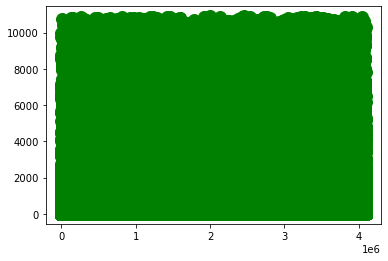

In [25]:
plt.plot(np.arange(len(y_test)),y_test ,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)


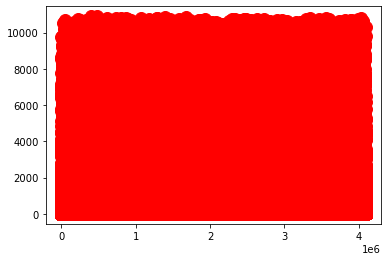

In [26]:
plt.plot(np.arange(len(y_prediction)),y_prediction ,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)

## The decision Tree regressor seems to be best model as most of the predictions are matching

In [27]:
print('Done. Time elapsed: {:.2f}s'.format(time.time() - total_start_time))

Done. Time elapsed: 3246.89s


## Save Dictionaries
np.save('ProdRecommed.npy', di) 
np.save('Residence_Code.npy', di1) 
np.save('Channel.npy', di2) 

x_train,x_test,y_train,y_test = train_test_split(traintesting.drop(['ProductRecommed'], axis=1), traintesting['ProductRecommed'],test_size = 0.30, random_state= 400)

x_train= x_train.astype('float64')

#,x_test,y_train,y_test

y_train= y_train.astype('float64')

x_test= x_test.astype('float64')
y_test = y_test.astype('float64')

import xgboost as xgb

dtrain = xgb.DMatrix(x_train, label=y_train)


dtest = xgb.DMatrix(x_test, label=y_test)

import xgboost as xgb
from sklearn.datasets import dump_svmlight_file

dump_svmlight_file(x_train, y_train, 'dtrain.svm', zero_based=True)
dump_svmlight_file(x_test, y_test, 'dtest.svm', zero_based=True)
dtrain_svm = xgb.DMatrix('dtrain.svm')
dtest_svm = xgb.DMatrix('dtest.svm')

!pip install torch
import torch
n_classes = len(torch.unique(y_train))
 

nc= len(y_train.unique())
nc


params = {
    'eta':0.1,
    #'n_estimators':1000,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softmax',
    'nthread':4,
    #'scale_pos_weight':1,
    'seed':27,
    'num_class':nc}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

bst = xgb.train(params=params, dtrain=dtrain, num_boost_round =20)
bst.dump_model('dump_xgboost.raw.txt')

y_pred = bst.predict(dtest)

from sklearn.metrics import precision_score

print precision_score(y_test, y_pred, average='macro')


from sklearn.externals import joblib

joblib.dump(bst, 'bst_model.pkl', compress=True)

## XGBOOST can not be used for our dataset as Num of classes (one of the mandatory parameters of XGBOOST) is having a value too high 10908 which give bad allocation error

## KNN Algorithm

from sklearn.cluster import KMeans

traintesting

In [9]:
traintesting1 = traintesting.head(1000000)

kmeans = KMeans(n_clusters=len(traintesting1['ProductRecommed'].unique()))

kmeans.fit(traintesting1)

kmeans.cluster_centers_
#traintesting1['ProductRecommed'].unique()

kmeans.labels_

def converter(cluster):
    if cluster=='Yes':
        return 1
    else:
        return 0

traintesting1['Cluster'] = kmeans.labels_

traintesting1

from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(['Cluster'],kmeans.labels_))
print(classification_report(df['Cluster'],kmeans.labels_))

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(traintesting.drop(['ProductRecommed'], axis=1), traintesting['ProductRecommed'],test_size = 0.30, random_state= 355)
#Performing Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
#Training KNN with k=5
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

In [ ]:
import pickle
filename = 'KNN_1.sav'
pickle.dump(classifier, open(filename, 'wb'))
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(x_test,y_test)
#y_predict= loaded_model.predict(x_test)
#print(y_predict)

In [ ]:
y_knn_pred = classifier.predict(x_test)

In [ ]:
classifier.score(x_test,y_test)

In [ ]:
print(confusion_matrix(y_test,y_knn_pred))

In [ ]:
print(classification_report(y_test,y_knn_pred))

In [ ]:
 error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

# Bayesian Optimisation

start_time = time.time()
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(traintesting1, traintesting1.ProductRecommed.values))[0]
print(len(bayesian_tr_index), len(bayesian_val_index))
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

bayesian_val_index

In [9]:
x_train,xg_valid,y_train,yg_valid = train_test_split(traintesting.drop(['ProductRecommed'], axis=1), traintesting['ProductRecommed'],test_size = 0.30, random_state= 355)

In [10]:
naive_clf = GaussianNB()
naive_clf.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [45]:
len(xg_valid)
#naive_clf.score(xg_valid,yg_valid)

4094193

In [42]:
xg_valid_test_naive= xg_valid.head(100000)

In [43]:
yg_valid_test_naive= yg_valid.head(100000)

In [34]:
y_naive_predict= naive_clf.predict(xg_valid_test_naive)

In [44]:
naive_clf.score(xg_valid_test_naive,yg_valid_test_naive)

0.00104

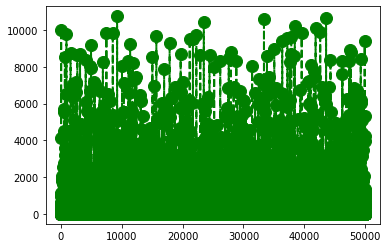

In [40]:
plt.plot(np.arange(len(yg_valid_test_naive)),yg_valid_test_naive ,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)


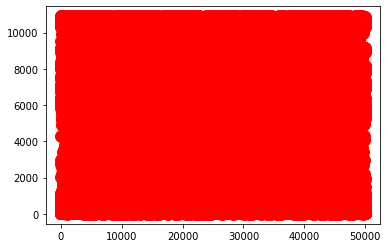

In [41]:
plt.plot(np.arange(len(y_naive_predict)),y_naive_predict ,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)

In [37]:
import sklearn.metrics as metrics
print('R^2:',metrics.r2_score(yg_valid_test_naive, y_naive_predict))
#print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(yg_valid_test_naive, y_naive_predict))
print('MSE:',metrics.mean_squared_error(yg_valid_test_naive, y_naive_predict))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yg_valid_test_naive, y_naive_predict)))

R^2: -76.61571085037049
MAE: 3342.06978
MSE: 27328794.1137
RMSE: 5227.6949139845565


In [47]:
import pickle
filename = 'Naive_Bayes.sav'
pickle.dump(naive_clf, open(filename, 'wb'))
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(x_test,y_test)
#y_predict= loaded_model.predict(x_test)
#print(y_predict)

## Naive Bayes is worst model as it has score of 1% only

In [60]:
x_train,xg_valid,y_train,yg_valid = train_test_split(traintesting1.drop(['ProductRecommed'], axis=1), traintesting1['ProductRecommed'],test_size = 0.30, random_state= 355)

In [73]:
# Function for LGB model creation for bayesian optimisation
start_time = time.time()
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
#    xg_train = lgb.Dataset(x_train.iloc[bayesian_tr_index][y_train].values,
#                           label=x_train.iloc[bayesian_tr_index][y_train].values,
#                           feature_name=y_train,
#                           free_raw_data = False
#                           )
#    xg_valid = lgb.Dataset(x_train.iloc[bayesian_val_index][y_train].values,
#                           label=x_train.iloc[bayesian_val_index][y_train].values,
#                           feature_name=y_train,
#                           free_raw_data = False
#                           ) 

    num_round = 5000
    clf = GaussianNB.fit(traintesting1,x_train,y_train)
    
    #clf = lgb.x_train(param, x_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    #predictions = clf.predict(x_train.iloc[bayesian_val_index][y_train].values, num_iteration=clf.best_iteration)   
    
    #score = roc_auc_score(x_train.iloc[bayesian_val_index][y_train].values, predictions)
    
    return clf

# Region Space for Bayesian Optimisation
region_space_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15),
}

LGB_BO = BayesianOptimization(LGB_bayesian, region_space_LGB, random_state=13)
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Done. Time elapsed: 0.00s


In [74]:
init_points = 5
n_iter = 5
LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


AttributeError: 'DataFrame' object has no attribute '_partial_fit'

In [49]:
start_time = time.time()
init_points = 5
n_iter = 5

LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


IndexError: positional indexers are out-of-bounds

In [ ]:
LGB_BO.max['ProductRecommed']

In [ ]:
LGB_BO.max['params']

In [ ]:
param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']),
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']),
        'save_binary': True,
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

# Model Interpreting
### ELI5

import eli5

model = lgb.LGBMClassifier(**param_lgb, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

#### Taking top 100 features and checking if the scores improves.

top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = train[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

* Without removal score : 0.89538
* With removal score : 0.883403

**So ELI5 isn't helping in reducing the features.**

# 5Fold Prediction & Submission

%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

y_pred_lgb = np.zeros(len(test))
num_round = 20000
for fold_n, (train_index, valid_index) in enumerate(folds.split(train[features], train[target])):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train[features].iloc[train_index], train[features].iloc[valid_index]
    y_train, y_valid = train[target].iloc[train_index], train[target].iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(
        param_lgb,
        train_data,num_round,
        valid_sets = [train_data, valid_data],
        verbose_eval=1000,
        early_stopping_rounds = 1000)
            
    y_pred_lgb += lgb_model.predict(test[features], num_iteration=lgb_model.best_iteration)/5

# Submitting the 5Fold LGB Predictions
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('sub_lgb.csv', index=False)

# This submission score 0.90038 on public leaderboard. (Almost top 9% in Public LB)

# Conclusion

TODO - 
1. H20 AutoML
1. Using XGBoost, Catboost
1. Ensembling, Stacking, Blending
1. Feature Removal